In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

import os

import pickle

from helpers.evaluation import run_BDTs
from helpers.physics_functions import *

In [2]:
# load in the data

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}

project_id = "dimu_bare"
particle_type = "upsilon"

flow_training_id = f"lowmass_{particle_type}_nojet_{project_id}"
flow_training_dir = os.path.join("models", f"{flow_training_id}/")

with open(f"models/{flow_training_id}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"processed_data/lowmass_{particle_type}_nojet_test_band_data", "rb") as infile: 
    test_dict = pickle.load(infile)
    
with open(f"models/{flow_training_id}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    print(configs)
    

feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']



In [5]:
# Assemble the test set

feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']

num_events_test_SR = test_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]
num_events_test_SB = test_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+test_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]

test_events_SB = np.empty((num_events_test_SB, len(feature_set)))
test_events_SR = np.empty((num_events_test_SR, len(feature_set)))


for i, feat in enumerate(feature_set):
    
    test_events_SR[:,i] = test_dict["SR"]["s_inj_data"][feat].reshape(-1,)
    
    
    loc_arr = np.concatenate((test_dict["SBL"]["s_inj_data"][feat], test_dict["SBH"]["s_inj_data"][feat]))
    test_events_SB[:,i] = loc_arr.reshape(-1,)


print(f"Total number of test events: {num_events_test_SR+num_events_test_SB}")


Total number of test events: 499485


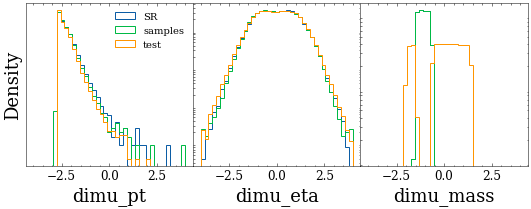

In [7]:
def hist_all_features(samples, labels, feature_set, plot_bound=3, yscale_log=False):
    scaled_feature_bins = [np.linspace(-plot_bound, plot_bound, 40) for i in range(len(feature_set))]   
    
    n_features = len(feature_set)
    fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))
        

    for i, feat in enumerate(feature_set):
        for j, samp in enumerate(samples):
            ax[i].hist(samp[:,i], bins = scaled_feature_bins[i], histtype = "step", density = True, label = labels[j])
         
        if yscale_log:
            ax[i].set_yscale("log")
        ax[i].set_xlabel(feat)
        ax[i].set_yticks([])
    ax[0].legend()
    ax[0].set_ylabel("Density")
    plt.subplots_adjust(wspace=0)
    plt.show()
  
  
hist_all_features([data_dict["SR"], data_dict["SR_samples"], test_events_SB], ["SR", "samples", "test"], feature_set, plot_bound = 4, yscale_log = True)

        

## Train the BDTs

Train to discriminate (flow samples in SR) from (test data in SR)

In [8]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [9]:
def run_BDT_bump_hunt(flow_samples_SR, data_samples_SR, data_samples_SB, num_folds, num_to_ensemble):
    
    """
    Classifier is trained only on SR data, to distinguish flow SR samples from SR data
    
    Classifier is evaluated on test data from SR AND SB
    """
    
    test_data_splits = {i:0 for i in range(num_folds)}
    scores_splits = {i:0 for i in range(num_folds)}
    
    
    flow_SR_splits = np.array_split(flow_samples_SR, num_folds)
    data_SR_splits = np.array_split(data_samples_SR, num_folds)
    data_SB_splits = np.array_split(data_samples_SB, num_folds)
    

    for i_fold in range(num_folds):
    
        print(f"Fold {i_fold}:")
        
        # Assemble the train / test data in a hacky way
        training_data = []
        training_labels = []
        testing_data = []
        
        for ii in range(num_folds):
            if ii != i_fold:
                training_data.append(flow_SR_splits[ii])
                training_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                training_data.append(data_SR_splits[ii])
                training_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
            else:
                testing_data.append(data_SR_splits[ii])
                testing_data.append(data_SB_splits[ii])
                
        X_train_fold = np.concatenate(training_data)
        Y_train_fold = np.concatenate(training_labels)
        X_test_fold = np.concatenate(testing_data)
        
        test_data_splits[i_fold] = X_test_fold
 

        print(f"X train shape: {X_train_fold.shape}, Y train shape: {Y_train_fold.shape}. X test shape: {X_test_fold.shape}." )

        # adjust for class weights
        class_weight = {0: 1, 1: sum(Y_train_fold==0)[0]/sum(Y_train_fold==1)[0]}
        class_weights = class_weight[0]*(1.0-Y_train_fold)+class_weight[1]*Y_train_fold

        Y_train_fold = Y_train_fold.reshape(-1,)
        class_weights = class_weights.reshape(-1,)

        print("Training class weights: ", class_weight)

        scores_fold = np.empty((X_test_fold.shape[0], num_to_ensemble))
   
        for i_tree in range(num_to_ensemble):

            print("   Tree number:", i_tree)
            np.random.seed(i_tree+1)

            tree = HistGradientBoostingClassifier(verbose=0, max_iter=200, max_leaf_nodes=31, validation_fraction=0.2, early_stopping=True)
            results_f = tree.fit(X_train_fold[:,:-1], Y_train_fold, sample_weight=class_weights)
            loc_scores = tree.predict_proba(X_test_fold[:,:-1])[:,1]
            scores_fold[:,i_tree] = loc_scores

            del results_f
            scores_splits[i_fold] = np.mean(scores_fold, axis = 1)
            
        print()


    return test_data_splits, scores_splits




In [10]:
# Train a classifier to discriminate SR samples from SR data

n_folds = 5

test_data_splits, scores_splits = run_BDT_bump_hunt(data_dict["SR_samples"], test_events_SR, test_events_SB, n_folds, 5)




Fold 0:
X train shape: (204314, 3), Y train shape: (204314, 1). X test shape: (99898, 3).
Training class weights:  {0: 1, 1: 0.8956226457107865}
   Tree number: 0
   Tree number: 1
   Tree number: 2
   Tree number: 3
   Tree number: 4

Fold 1:
X train shape: (204315, 3), Y train shape: (204315, 1). X test shape: (99898, 3).
Training class weights:  {0: 1, 1: 0.8956319236978345}
   Tree number: 0
   Tree number: 1
   Tree number: 2
   Tree number: 3
   Tree number: 4

Fold 2:
X train shape: (204315, 3), Y train shape: (204315, 1). X test shape: (99897, 3).
Training class weights:  {0: 1, 1: 0.8956319236978345}
   Tree number: 0
   Tree number: 1
   Tree number: 2
   Tree number: 3
   Tree number: 4

Fold 3:
X train shape: (204316, 3), Y train shape: (204316, 1). X test shape: (99896, 3).
Training class weights:  {0: 1, 1: 0.895623614113543}
   Tree number: 0
   Tree number: 1
   Tree number: 2
   Tree number: 3
   Tree number: 4

Fold 4:
X train shape: (204316, 3), Y train shape: (20431

## Analysis

### True bump hunt

- Define a polynomial form for the background fit
- For each cut on the classifier score:
  - Fit the background on the cut SB data
  - Estimate N_bkg
  - Calculate S/B, S/sqrt(B)



In [11]:
with open(f"processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
sorted_masses_splits = {}
sorted_features_splits = {}

for i_fold in range(n_folds):
    
    # sort the scores
    loc_sorted_indices = np.argsort(scores_splits[i_fold])
    
    # get the true masses from low to high score
    sorted_masses_splits[i_fold] = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1][loc_sorted_indices]).reshape(-1,1))
    # and features
    sorted_features_splits[i_fold] = test_data_splits[i_fold][loc_sorted_indices]





118.37013222299797 96 1.2330222106562287

106.4400788198505 96 1.1087508210401094

122.16732978137004 96 1.2725763518892712

132.86120732406687 96 1.3839709096256965

84.70115900427376 96 0.8823037396278517


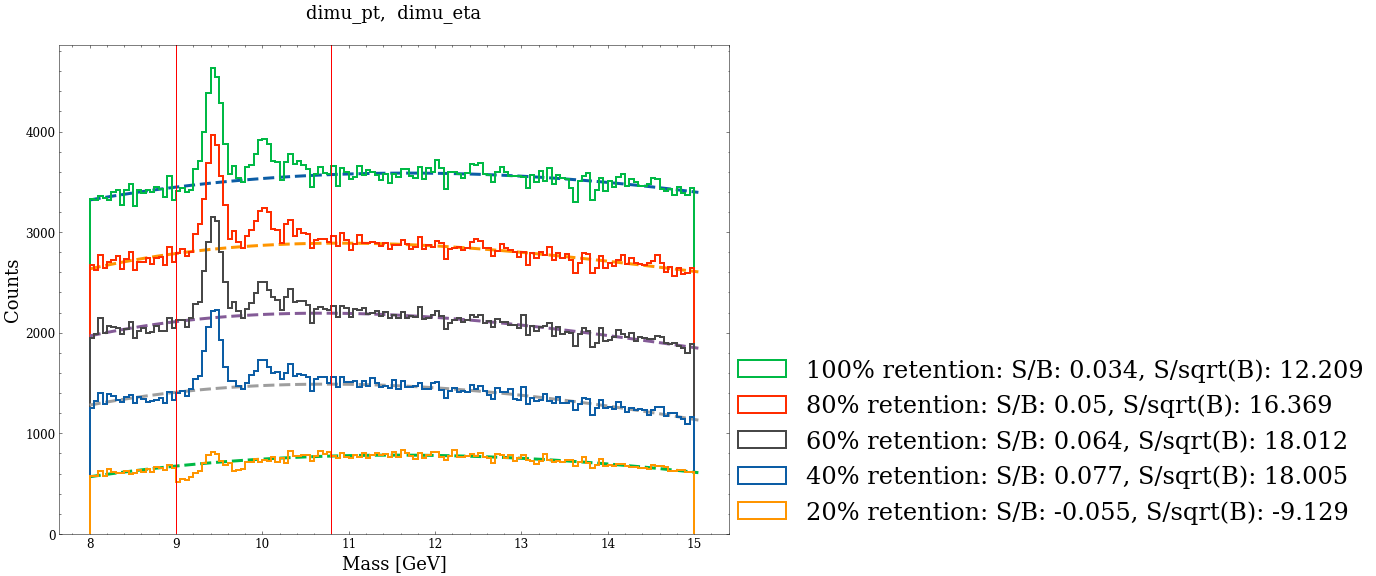

In [12]:
if (particle_type == "eta") or (particle_type == "eta_pt35"):
    SR_left, SR_right = 0.527, 0.567
    left_bound, right_bound = 0.3, 0.72
    width = 0.01


elif particle_type == "upsilon":
    SR_left, SR_right = 9, 10.8
    left_bound, right_bound = 8, 15
    width = 0.05

    
elif particle_type == "none":
    SR_left, SR_right = 17.5, 19.5
    left_bound, right_bound = 14, 23
    width = 0.1



plot_bins = np.arange(left_bound, right_bound+ width, width)
remove_right_edge = True



fit_type = "cubic"

if fit_type == "cubic":
    p0  = [5000, -20000, 30000, -10000]
    bkg_fit_function = bkg_fit_cubic
    n_dof_fit = 4
    
elif  fit_type == "quintic":
    p0  = [5000, -20000, 30000, -10000, 0, 0]
    bkg_fit_function = bkg_fit_quintic
    n_dof_fit = 6


plt.figure(figsize = (12, 9))
for percent in [100, 80, 60, 40, 20]:
    
    print()
    
    filtered_masses = []
    
    for i_fold in range(n_folds):
        # grab the top percent of events FROM EACH FOLD
        loc_num_events_to_take = int(percent*sorted_masses_splits[i_fold].shape[0]/100)
        filtered_masses.append(np.array(sorted_masses_splits[i_fold][-loc_num_events_to_take:]).reshape(-1,1))
    
    filtered_masses = np.concatenate(filtered_masses)
    
    
    popt, chi2, dof_data = curve_fit_m_inv(filtered_masses, bkg_fit_function, left_bound, right_bound, SR_left, SR_right, width, p0, remove_right_edge = True)
    
    #print(popt)
    n_dof = dof_data - n_dof_fit
    print(chi2, n_dof, chi2/n_dof)
    x = np.linspace(left_bound, right_bound + width, 100)
    plt.plot(x, bkg_fit_function(x, *popt), lw = 3, linestyle = "dashed")
    
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, bkg_fit_function, left_bound, right_bound, SR_left, SR_right, width, popt)
    
    plt.hist(filtered_masses, bins = plot_bins, lw = 2, histtype = "step", label = f"{percent}% retention: S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")
    
    
    
    
plt.title(",  ".join(feature_set[:-1])+"\n", fontsize = 18) 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "red")
plt.axvline(SR_right, color= "red")

plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.show()

Plot all the other features

In [13]:
n_features = len(feature_set)
plot_bound=3
scaled_feature_bins = [np.linspace(-plot_bound, plot_bound, 40) for i in range(len(feature_set))]   

In [ ]:
# full training range

fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))

for percent in [100, 80, 60, 40, 20]:

    # grab the top percent of events
    num_events_to_take = int(percent*num_test_events/100)
    filtered_features = sorted_features[-num_events_to_take:]
    
    masses = scaler.inverse_transform(filtered_features[:,i].reshape(-1,1))
    
    for i, feat in enumerate(feature_set):
        if feat != "dimu_mass":
            ax[i].hist(filtered_features[:,i], bins = scaled_feature_bins[i], histtype = "step", density = False, label = f"{percent}%")
        else:
            ax[i].hist(masses, bins = np.linspace(left_bound, right_bound, 40), histtype = "step", density = False, label = f"{percent}%")
            
        ax[i].set_yscale("log")
        ax[i].set_xlabel(feat)
        ax[i].set_yticks([])

        
plt.legend(loc = (1, 0), fontsize = 24)
plt.subplots_adjust(wspace=0)
ax[0].set_title("Full test set")
plt.show()



NameError: name 'num_test_events' is not defined

In [ ]:
# in SR

fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))

for percent in [100, 80, 60, 40, 20]:

    # grab the top percent of events
    num_events_to_take = int(percent*num_test_events/100)
    filtered_features = sorted_features[-num_events_to_take:]
    
    masses = scaler.inverse_transform(filtered_features[:,i].reshape(-1,1))
    in_SR = (masses >= SR_left) & (masses <= SR_right)

    
    for i, feat in enumerate(feature_set):
        if feat != "dimu_mass":
            ax[i].hist(filtered_features[:,i].reshape(-1,1)[in_SR], bins = scaled_feature_bins[i], histtype = "step", density = False, label = f"{percent}%")
        else:
            ax[i].hist(masses[in_SR], bins = np.linspace(left_bound, right_bound, 40), histtype = "step", density = False, label = f"{percent}%")
            
        ax[i].set_yscale("log")
        ax[i].set_xlabel(feat)
        ax[i].set_yticks([])
        

        
plt.legend(loc = (1, 0), fontsize = 24)
plt.subplots_adjust(wspace=0)
ax[0].set_title("SR test set")
plt.show()
